In [1]:
import os
import warnings
warnings.filterwarnings("ignore")

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, average_precision_score, precision_recall_curve
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

from lightgbm import LGBMClassifier
import joblib

# ✅ FIXED try-except indentation
try:
    import shap
    SHAP_INSTALLED = True
except:
    SHAP_INSTALLED = False

try:
    import optuna
    OPTUNA_INSTALLED = True
except:
    OPTUNA_INSTALLED = False

SEED = 42
TRAIN_CSV ="C:/Users/harshitha y/Downloads/archive (2)/UNSW_NB15_training-set.csv"
TEST_CSV  ="C:/Users/harshitha y/Downloads/archive (2)/UNSW_NB15_testing-set.csv"

In [3]:
df_train = pd.read_csv("C:/Users/harshitha y/Downloads/archive (2)/UNSW_NB15_training-set.csv")
df_test = pd.read_csv("C:/Users/harshitha y/Downloads/archive (2)/UNSW_NB15_testing-set.csv")
df = pd.concat([df_train, df_test], ignore_index=True)

print("✅ Loaded dataset successfully!")
print("Shape:", df.shape)
display(df.head())


✅ Loaded dataset successfully!
Shape: (257673, 45)


,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,1,0.000011,udp,-,INT,2,0,496,0,90909.0902,...,1,2,0,0,0,1,2,0,Normal,0
1,2,0.000008,udp,-,INT,2,0,1762,0,125000.0003,...,1,2,0,0,0,1,2,0,Normal,0
2,3,0.000005,udp,-,INT,2,0,1068,0,200000.0051,...,1,3,0,0,0,1,3,0,Normal,0
3,4,0.000006,udp,-,INT,2,0,900,0,166666.6608,...,1,3,0,0,0,2,3,0,Normal,0
4,5,0.000010,udp,-,INT,2,0,2126,0,100000.0025,...,1,3,0,0,0,2,3,0,Normal,0


In [4]:
print(df.info())
print("\nMissing values:\n", df.isna().sum().sort_values(ascending=False).head())

if 'label' in df.columns:
    print("\nLabel counts:\n", df['label'].value_counts())

if 'attack_cat' in df.columns:
    print("\nAttack categories:\n", df['attack_cat'].value_counts())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 257673 entries, 0 to 257672
Data columns (total 45 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   id                 257673 non-null  int64  
 1   dur                257673 non-null  float64
 2   proto              257673 non-null  object 
 3   service            257673 non-null  object 
 4   state              257673 non-null  object 
 5   spkts              257673 non-null  int64  
 6   dpkts              257673 non-null  int64  
 7   sbytes             257673 non-null  int64  
 8   dbytes             257673 non-null  int64  
 9   rate               257673 non-null  float64
 10  sttl               257673 non-null  int64  
 11  dttl               257673 non-null  int64  
 12  sload              257673 non-null  float64
 13  dload              257673 non-null  float64
 14  sloss              257673 non-null  int64  
 15  dloss              257673 non-null  int64  
 16  si

In [5]:
drop_cols = [c for c in ['srcip', 'dstip', 'id'] if c in df.columns]
df = df.drop(columns=drop_cols)

In [6]:
# ✅ Ensure label column exists
if 'label' not in df.columns and 'attack_cat' in df.columns:
    df['label'] = (~df['attack_cat'].astype(str).str.lower().isin(['normal', 'normal-l'])).astype(int)

# ✅ Separate features and target
X = df.drop(columns=[c for c in ['label', 'attack_cat'] if c in df.columns])
y = df['label'].astype(int)

# ✅ Train-test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=SEED
)


In [7]:
selected_features = ["dur", "proto", "state", "sbytes", "dbytes"]




In [8]:
print(df.columns.tolist())


['dur', 'proto', 'service', 'state', 'spkts', 'dpkts', 'sbytes', 'dbytes', 'rate', 'sttl', 'dttl', 'sload', 'dload', 'sloss', 'dloss', 'sinpkt', 'dinpkt', 'sjit', 'djit', 'swin', 'stcpb', 'dtcpb', 'dwin', 'tcprtt', 'synack', 'ackdat', 'smean', 'dmean', 'trans_depth', 'response_body_len', 'ct_srv_src', 'ct_state_ttl', 'ct_dst_ltm', 'ct_src_dport_ltm', 'ct_dst_sport_ltm', 'ct_dst_src_ltm', 'is_ftp_login', 'ct_ftp_cmd', 'ct_flw_http_mthd', 'ct_src_ltm', 'ct_srv_dst', 'is_sm_ips_ports', 'attack_cat', 'label']


In [9]:
# Ensure these columns exist in your dataset
X = df[selected_features]
y = df['label'].astype(int)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=SEED
)


In [10]:
# Build preprocessing pipeline
num_cols = [c for c in X_train.columns if pd.api.types.is_numeric_dtype(X_train[c])]
cat_cols = [c for c in X_train.columns if c not in num_cols]


from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder


num_pipeline = Pipeline([
("imputer", SimpleImputer(strategy="median")),
("scaler", StandardScaler()),
])


cat_pipeline = Pipeline([
("imputer", SimpleImputer(strategy="most_frequent")),
("encoder", OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
])


from sklearn.compose import ColumnTransformer


preprocessor = ColumnTransformer([
("num", num_pipeline, num_cols),
("cat", cat_pipeline, cat_cols)
])

In [11]:
clf = LGBMClassifier(n_estimators=300, learning_rate=0.05, class_weight='balanced', random_state=SEED)


pipeline = ImbPipeline(steps=[
("preprocessor", preprocessor),
("smote", SMOTE(random_state=SEED)),
("clf", clf)
])


pipeline.fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 131738, number of negative: 131738
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002703 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 906
[LightGBM] [Info] Number of data points in the train set: 263476, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


,steps,"[('preprocessor', ...), ('smote', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


              precision    recall  f1-score   support

           0       0.86      0.94      0.90     18600
           1       0.97      0.91      0.94     32935

    accuracy                           0.92     51535
   macro avg       0.91      0.93      0.92     51535
weighted avg       0.93      0.92      0.92     51535

ROC-AUC: 0.9845864247107776
PR-AUC: 0.9914818257773086


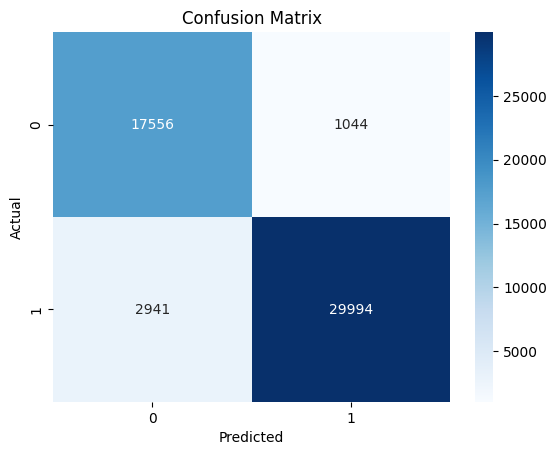

In [12]:
y_pred = pipeline.predict(X_test)
y_proba = pipeline.predict_proba(X_test)[:, 1]


print(classification_report(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_proba))
print("PR-AUC:", average_precision_score(y_test, y_proba))


cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

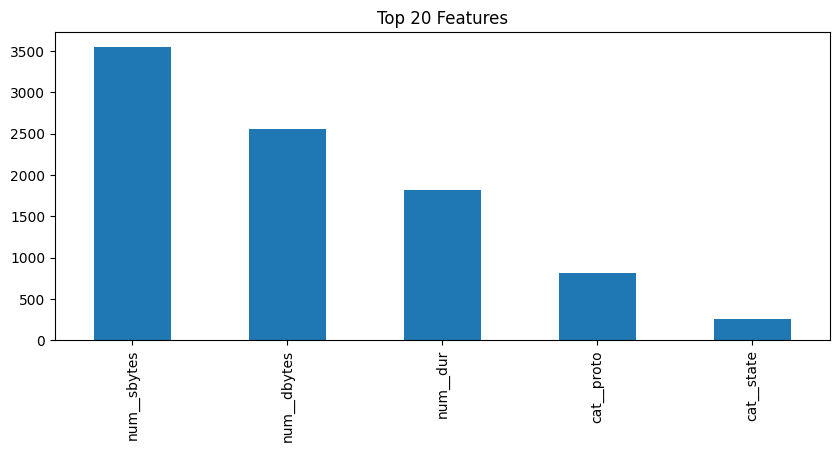

In [13]:
clf_model = pipeline.named_steps['clf']
feat_names = pipeline.named_steps['preprocessor'].get_feature_names_out()
importances = pd.Series(clf_model.feature_importances_, index=feat_names).sort_values(ascending=False)


importances.head(20).plot(kind='bar', figsize=(10, 4))
plt.title("Top 20 Features")
plt.show()

In [14]:
if SHAP_INSTALLED:
    import shap
    X_sample = X_test.sample(min(200, len(X_test)), random_state=SEED)
    explainer = shap.TreeExplainer(clf_model)
    shap_values = explainer.shap_values(preprocessor.transform(X_sample))
    shap.summary_plot(shap_values, preprocessor.transform(X_sample), feature_names=feat_names)
else:
    print("SHAP not installed. Skipping explainability.")


SHAP not installed. Skipping explainability.


In [15]:
from sklearn.preprocessing import OrdinalEncoder

categorical_features = ["proto", "state"]
encoder = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)

X_train[categorical_features] = encoder.fit_transform(X_train[categorical_features])
X_test[categorical_features] = encoder.transform(X_test[categorical_features])


In [16]:
joblib.dump(encoder, "encoder.pkl")


['encoder.pkl']

In [17]:
from sklearn.preprocessing import OrdinalEncoder
import joblib
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split

# Selected features
selected_features = ["dur", "proto", "state", "sbytes", "dbytes"]
categorical_features = ["proto", "state"]

X = df[selected_features]
y = df['label'].astype(int)

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=SEED
)

# Load your saved encoder
encoder = joblib.load("encoder.pkl")

# Transform categorical columns
X_train[categorical_features] = encoder.transform(X_train[categorical_features])
X_test[categorical_features] = encoder.transform(X_test[categorical_features])

# Train LightGBM
model = LGBMClassifier(random_state=SEED)
model.fit(X_train, y_train)

# Save model
joblib.dump(model, "lgbm_unsw_pipeline.pkl")
print("✅ Model retrained and saved successfully!")


[LightGBM] [Info] Number of positive: 131738, number of negative: 74400
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002460 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 905
[LightGBM] [Info] Number of data points in the train set: 206138, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.639077 -> initscore=0.571359
[LightGBM] [Info] Start training from score 0.571359
✅ Model retrained and saved successfully!


In [18]:
!pip install streamlit


In [20]:
# 1️⃣ Define the UI code
ui_code = """
import streamlit as st
import pandas as pd
import joblib

# ------------------------------
# Load trained model and encoder
# ------------------------------
MODEL_PATH = "lgbm_unsw_pipeline.pkl"
ENCODER_PATH = "encoder.pkl"

model = joblib.load(MODEL_PATH)
encoder = joblib.load(ENCODER_PATH)

st.title("🔎 Network Traffic Intrusion Detection (Batch Upload)")
st.write("Upload a CSV file containing network traffic features. The model will predict malicious/normal traffic.")

# ------------------------------
# File uploader
# ------------------------------
uploaded_file = st.file_uploader("Choose a CSV file", type="csv")

if uploaded_file is not None:
    df = pd.read_csv(uploaded_file)
    st.write("Preview of uploaded data:")
    st.dataframe(df.head())

    # Ensure all required features exist
    required_features = list(encoder.feature_names_in_)  # features used in training
    missing_cols = [col for col in required_features if col not in df.columns]
    
    if missing_cols:
        st.error(f"Missing columns in uploaded file: {missing_cols}")
    else:
        # Encode categorical features
        try:
            df[encoder.feature_names_in_] = df[encoder.feature_names_in_]
            df[encoder.feature_names_in_] = encoder.transform(df[encoder.feature_names_in_])
        except Exception as e:
            st.error(f"Encoding error: {e}")
        
        # Predict
        predictions = model.predict(df)
        probabilities = model.predict_proba(df)[:, 1]
        
        df['Prediction'] = predictions
        df['Attack_Probability'] = probabilities

        st.write("✅ Prediction results:")
        st.dataframe(df.head())

        # Allow download of results
        csv = df.to_csv(index=False)
        st.download_button(
            label="Download Predictions as CSV",
            data=csv,
            file_name='predictions.csv',
            mime='text/csv'
        )
"""

In [ ]:
!streamlit run ui.py